# 1. Setup and Data Loading

In [ ]:
!pip install opendatasets

In [ ]:
#load dataset from kaggle
import opendatasets as od

od.download("https://www.kaggle.com/datasets/shahriar26s/malaria-detection/data")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: afbtechie
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/shahriar26s/malaria-detection


100%|██████████| 63.3M/63.3M [00:00<00:00, 858MB/s]

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import models
from sklearn.metrics import classification_report, confusion_matrix
import time

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# 2. Data Preparation

In [ ]:
#Define Paths
data_dir = '/content/malaria-detection/Malaria Dataset'

train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')
valid_dir = os.path.join(data_dir, 'valid')

In [ ]:
#Transforms and Loaders
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = ImageFolder(train_dir, transform=transform)
test_dataset = ImageFolder(test_dir, transform=transform)
valid_dataset = ImageFolder(valid_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

class_names = train_dataset.classes
print(f"Classes: {class_names}")

Classes: ['Parasitized', 'Uninfected']


# 3. Data Visualization

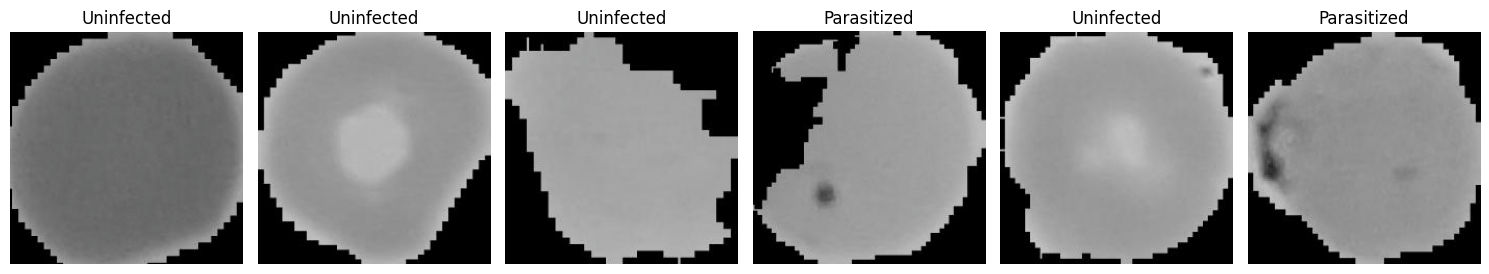

In [ ]:
def show_sample_images(loader):
    data_iter = iter(loader)
    images, labels = next(data_iter)
    fig, axes = plt.subplots(1, 6, figsize=(15, 5))
    for i in range(6):
        img = images[i].permute(1, 2, 0).numpy()
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        axes[i].imshow(np.clip(img, 0, 1))
        axes[i].set_title(class_names[labels[i]])
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

show_sample_images(train_loader)

# 4. Model Setup - ResNet18

In [ ]:
model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 179MB/s]


# 5. Model Training

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def train_model(model, train_loader, valid_loader, epochs=5):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}")

        # Validation accuracy
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        print(f"Validation Accuracy: {(100 * correct / total):.2f}%")

train_model(model, train_loader, valid_loader)

Epoch [1/5], Loss: 0.1998
Validation Accuracy: 95.05%
Epoch [2/5], Loss: 0.1549
Validation Accuracy: 94.81%
Epoch [3/5], Loss: 0.1407
Validation Accuracy: 95.77%
Epoch [4/5], Loss: 0.1329
Validation Accuracy: 94.73%
Epoch [5/5], Loss: 0.1251
Validation Accuracy: 96.25%


# 6. Model Evaluation

              precision    recall  f1-score   support

 Parasitized       0.95      0.94      0.95       309
  Uninfected       0.95      0.95      0.95       317

    accuracy                           0.95       626
   macro avg       0.95      0.95      0.95       626
weighted avg       0.95      0.95      0.95       626



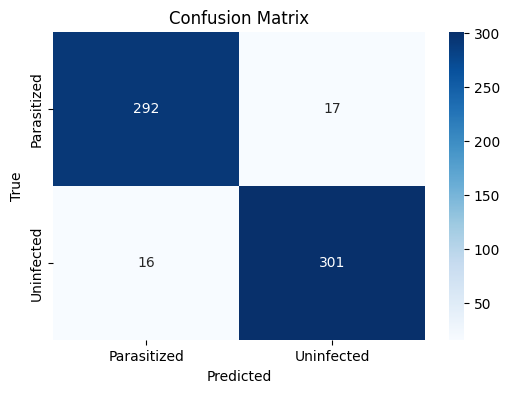

In [ ]:
def evaluate(model, test_loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    print(classification_report(y_true, y_pred, target_names=class_names))
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

evaluate(model, test_loader)

# 7. Sample Predictions

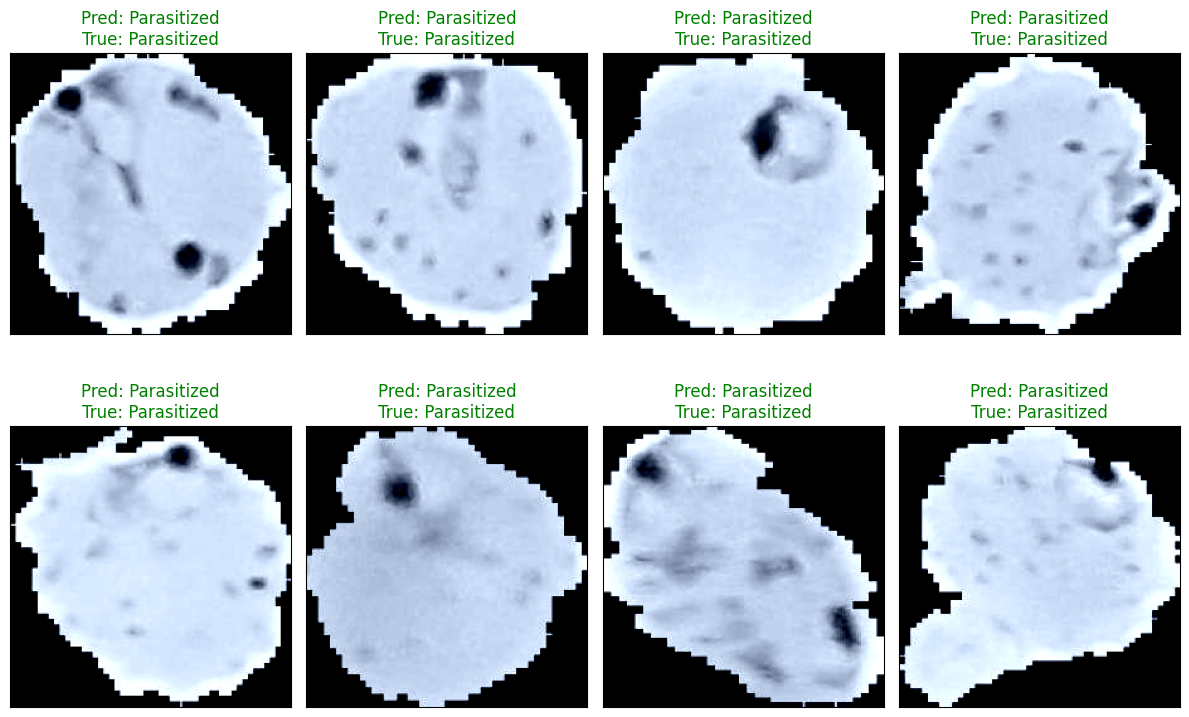

In [ ]:
#sample predictions with predicted vs. true labels
import random
import matplotlib.pyplot as plt

dataiter = iter(test_loader)
images, labels = next(dataiter)
images = images.to(device)
labels = labels.to(device)

model.eval()
with torch.no_grad():
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

fig = plt.figure(figsize=(12, 8))
for idx in range(8):
    ax = fig.add_subplot(2, 4, idx+1, xticks=[], yticks=[])
    img = images[idx].cpu().permute(1, 2, 0).numpy()
    img = img * 0.5 + 0.5  # unnormalize if needed
    ax.imshow(img)
    pred_label = class_names[preds[idx]]
    true_label = class_names[labels[idx]]
    color = 'green' if preds[idx] == labels[idx] else 'red'
    ax.set_title(f"Pred: {pred_label}\nTrue: {true_label}", color=color)

plt.tight_layout()
plt.show()

#8. Model Saving

In [ ]:
torch.save(model.state_dict(), 'malaria_resnet18.pth')

#9. Environment Check

In [ ]:
!python --version

Python 3.11.12
